# Downloading and Caching Datasets

In [1]:
# Downloading and Caching Datasets
# maintain a dictionary DATA_HUB that maps a string (the name of the dataset)
# to a tuple containing both the URL to locate the dataset 
# and the SHA-1 key that verifies the integrity of the file.
# All such datasets are hosted at the site whose address is DATA_URL

In [2]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [12]:
def download(name, cache_dir=os.path.join('..', 'data')):
    """Downloading a file inseted into DATA_HUB, return the local filename.

    Args:
        name (_type_): _description_
        cache_dir (_type_, optional): _description_. Defaults to os.path.join('..', 'data').
    """
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True) 
    # creating cache file path, if the path exists, do not raise error
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname
        

1. 确认想下载的数据信息是否在DATA_HUB中
2. 从DATA_HUB中提取数据的网站和SHA1密钥
3. 创建所有数据的缓存地址，如果地址存在，无需报错
4. 创建指定数据的地址，如果该数据文件存在，创建一个空的SHA1密钥，然后打开这个数据，循环每次读取1MB数据，生成SHA1简报，然后用该SHA1密钥（简报）对比存在DATA_HUB中的数据简报，如果相等，说明曾经缓存过该数据，返回文件地址。
5. 否则就用request.get从相关网址下载
6. 使用with open write来下载数据，这里将数据以二进制形式写入（wb），我个人猜测可能是二进制写入适合各种数据类型（比如压缩文件等等），只需要用encode转化就行，也有Mac和Win对于换行符定义的问题，用二进制写入可以避免。另外wb还有一个作用就是当该文件不存在的时候，在当前目录创建该文件。如果存在则会overwrite，这点要小心。可以用a或者ab关键字替代，表示追加。
7. 另外还有一个要注意，with open后面就不需要添加close了，这个操作在with里面已经实现。其他情况需要添加close操作。

说句实话，我不是很喜欢上面这个函数的逻辑。
所以在执行上面这个函数之前，你需要把你想下载的数据链接和文件SHA-1密钥存入DATA_HUB这个字典里面，与此同时起好数据的名称，数据的名称就是字典的键。然后再调用download函数来将数据下载到本地。这个download的功能具体是：
查看本地是否有该文件，创建本地路径
如果本地有这个文件，那么就循环读取1048576字节，也就是1MB的数据，转化成SHA-1密钥，最后得到总密钥和输入DATA_HUB的密钥进行对比，如果相同，那么就说明该数据已经下载过了。这其实就是一个利用文件加密摘要做本地数据校验。
如果本地没有这个文件，就从输入的URL中获取并写入本地文件中。

一开始不是很喜欢这个函数逻辑
但是详细分析之后发现其中包含的本地文件校验的过程，非常值得学习。

In [27]:
def download_extract(name, folder=None): 
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    # 输出上级路径
    data_dir, ext = os.path.splitext(fname)
    # 分离文件名和拓展名
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    if folder:
        fp.extractall(os.path.join(base_dir, folder))
    else:
        fp.extractall(os.path.join(base_dir, data_dir))
    #从归档中提取所有成员放入当前目录
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [3]:
%matplotlib inline
import os
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# Pascal VOC2012 语义分割数据集

In [4]:
DATA_HUB['voc2012'] = (DATA_URL + 'VOCtrainval_11-May-2012.tar',
                           '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

voc_dir = download_extract('voc2012')

NameError: name 'download_extract' is not defined

In [5]:
voc_dir = '../data/VOCdevkit/VOC2012'

In [6]:
def read_voc_images(voc_dir, is_train=True):
    """读取所有VOC图像并标注"""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                            'train.txt' if is_train else 'val.txt')
    mode = torchvision.io.image.ImageReadMode.RGB
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'JPEGImages', f'{fname}.jpg'
        )))
        labels.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'SegmentationClass', f'{fname}.png'
        ), mode))
    return features, labels

train_features, train_labels = read_voc_images(voc_dir, True)

In [7]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

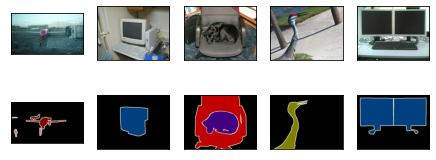

In [8]:
n = 5
imgs = train_features[0:n] + train_labels[0:n]
imgs = [img.permute(1,2,0) for img in imgs]
show_images(imgs, 2, n)

In [9]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [10]:
def voc_colormap2label():
    """构建从RGB到VOC类别索引的映射"""
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label

def voc_label_indices(colormap, colormap2label):
    """将VOC标签中的RGB值映射到它们的类别索引"""
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

上面就是想让三维数组映射为一个一维数组，有点像哈希算法，或者说是256进制转化为20进制。
学习一下哈希算法！数学理论上的
这样的作法是为了提高python的计算效率，原理就是秦九韶算法。

In [11]:
y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]),
 'aeroplane')

# 预处理数据

在图像识别中，有的时候会通过缩放图像使其符合模型的输入形状。然而在语义分割中，如果缩放图像，很容易和mask，也就是像素label产生不精确的映射。为了避免这样的问题，一般将图像裁剪为固定尺寸，而不是再缩放。具体来说，我们使用图像增广中的随机裁剪，裁剪输入图像和标签相同的区域。

In [12]:
def voc_rand_crop(feature, label, height, width):
    """随机裁剪特征和标签图像"""
    rect = torchvision.transforms.RandomCrop.get_params(
        feature, (height, width)
    )
    # Get parameters for crop for a random crop
    # Parameters: 
    # img: Image to be cropped
    # output_size (tuple) : Expected output size of the crop
    # Returns:Params (i, j, h, w) to be passed to crop for random crop
    feature = torchvision.transforms.functional.crop(feature, *rect)
    # '*' here is an idiom used to unpack argument lists when calling
    # a  function
    # '*' in a function definition is used to allow arbitrary number 
    # arguments to functions. THe *args will give you all function
    # parameters as a tuple. 
    # '**' will give you all keyword arguments except for those corresponding
    # to a formal parameters as a dictionary. 
    # https://stackoverflow.com/questions/36901/what-does-double-star-asterisk-and-star-asterisk-do-for-parameters
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label

# 自定义语义分割数据集类

In [13]:
class VOCSegDataset(torch.utils.data.Dataset):
    """一个用于加载VOC数据集的自定义数据集"""
    
    def __init__(self, is_train, crop_size, voc_dir):
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')
        
    def normalize_image(self, img):
        return self.transform(img.float() / 255)
    
    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and
            img.shape[2] >= self.crop_size[1]
        )]
    
    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature,  voc_label_indices(label, self.colormap2label))
    
    def __len__(self):
        return len(self.features)

In [14]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples


In [16]:
batch_size = 4
train_iter = torch.utils.data.DataLoader(voc_train, batch_size, shuffle=True,
                                    drop_last=True)

In [17]:
X, Y = next(iter(train_iter))

In [18]:
print(X.shape)
print(Y.shape)

torch.Size([4, 3, 320, 480])
torch.Size([4, 320, 480])


# 整合所有组件

In [ ]:
def load_data_voc(batch_size, crop_size):
    """加载VOC语义分割数据集"""
    voc_dir = download_extract('voc2012', os.path.join(
        'VOCdevkit', 'VOC2012'))
    num_workers = 4
    train_iter = torch.utils.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir), batch_size,
        shuffle=True, drop_last=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size,
        drop_last=True, num_workers=num_workers)
    return train_iter, test_iter